## Lab 3

Parth Patel - 
8629824

### Imports

In [37]:
import os
import shutil
import random
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D


### Obtain the Data

This data is going to be loaded from a kaggle dataset, namely at this source: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

In [ ]:


# Define source and targets
source_dir = 'train/train'
cat_target = 'data/train/cats'
dog_target = 'data/train/dogs'

# Ensure clean folders
for folder in [cat_target, dog_target]:
    os.makedirs(folder, exist_ok=True)
    for f in os.listdir(folder):
        os.remove(os.path.join(folder, f))

# Get image lists
all_files = os.listdir(source_dir)
cat_files = [f for f in all_files if f.startswith('cat')]
dog_files = [f for f in all_files if f.startswith('dog')]

# Pick 2500 each
n = 2500
selected_cats = random.sample(cat_files, n)
selected_dogs = random.sample(dog_files, n)

# Define helper function
def copy_file(filename, target_folder):
    shutil.copy(os.path.join(source_dir, filename), os.path.join(target_folder, filename))

# Parallel copy
with ThreadPoolExecutor() as executor:
    executor.map(copy_file, selected_cats, [cat_target]*n)
    executor.map(copy_file, selected_dogs, [dog_target]*n)

print(f"Done: Copied {n} cat and {n} dog images.")


Done: Copied 2500 cat and 2500 dog images.


### EDA

First lets check if the dataset is balanced between cats and dogs.

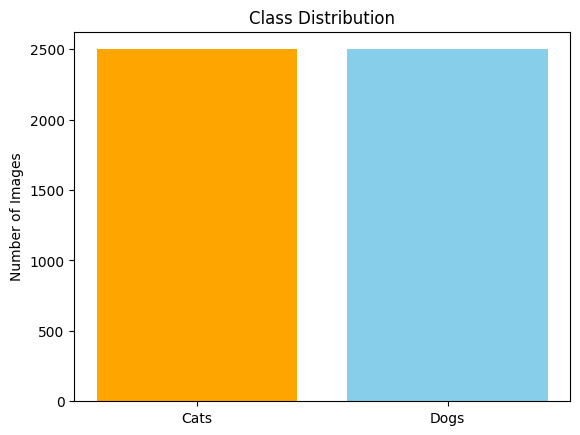

Cats: 2500 | Dogs: 2500


In [29]:

cat_dir = 'data/train/cats'
dog_dir = 'data/train/dogs'

num_cats = len(os.listdir(cat_dir))
num_dogs = len(os.listdir(dog_dir))

plt.bar(['Cats', 'Dogs'], [num_cats, num_dogs], color=['orange', 'skyblue'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

print(f"Cats: {num_cats} | Dogs: {num_dogs}")

This is good we can see that it is a balanced dataset. This will prevent some bias within the model.

Let's now sample ssome images and verify if they are correct manually. 

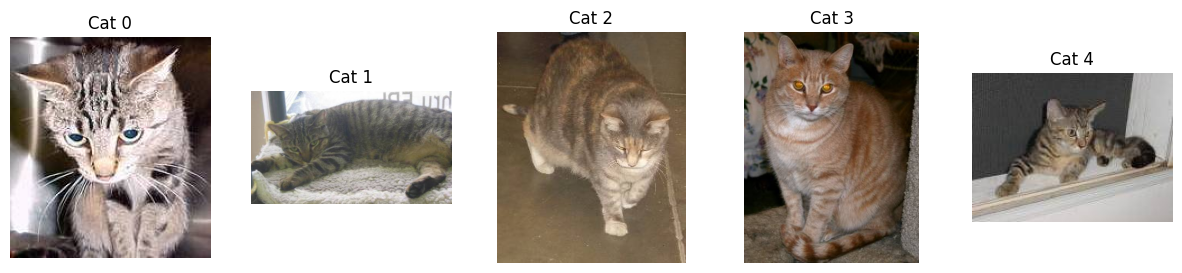

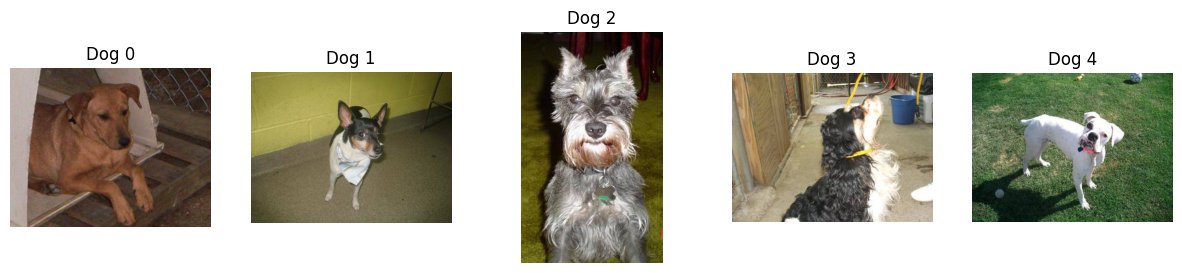

In [30]:


def show_sample_images(folder, label):
    files = os.listdir(folder)[:5]
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(files):
        img = Image.open(os.path.join(folder, fname))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{label} {i}")
        plt.axis('off')
    plt.show()

show_sample_images(cat_dir, 'Cat')
show_sample_images(dog_dir, 'Dog')


Clearly there are no mistakes here, so we can move forward.

Lets check the pixel intensity for each chosen image.

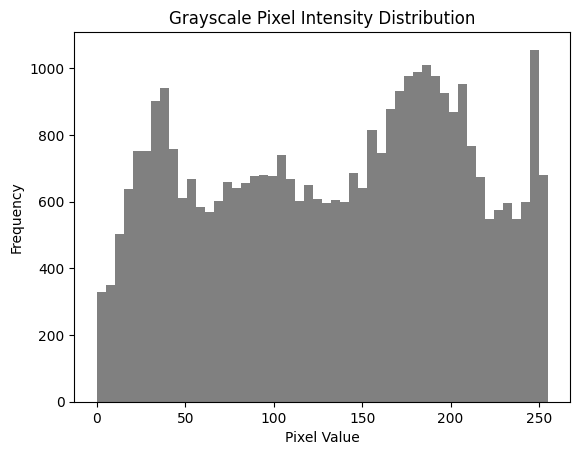

In [31]:
import numpy as np

img = Image.open(os.path.join(cat_dir, os.listdir(cat_dir)[0])).convert('L')  # grayscale
pixels = np.array(img).flatten()

plt.hist(pixels, bins=50, color='gray')
plt.title("Grayscale Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

This shows the general brightness. We can normalize pixel values (rescale to [0, 1]) for more consistent model behavior.

### Image Size Statistics

In [32]:


# Sample 500 of each
cat_files = os.listdir('data/train/cats')[:500]
dog_files = os.listdir('data/train/dogs')[:500]

image_data = []

for fname in cat_files:
    path = os.path.join('data/train/cats', fname)
    with Image.open(path) as img:
        width, height = img.size
        image_data.append({'label': 'cat', 'width': width, 'height': height})

for fname in dog_files:
    path = os.path.join('data/train/dogs', fname)
    with Image.open(path) as img:
        width, height = img.size
        image_data.append({'label': 'dog', 'width': width, 'height': height})

df = pd.DataFrame(image_data)
df['aspect_ratio'] = df['width'] / df['height']


Display these

In [33]:
stats = df.groupby('label')[['width', 'height', 'aspect_ratio']].describe()
print(stats)

       width                                                         height  \
       count     mean         std   min     25%    50%    75%    max  count   
label                                                                         
cat    500.0  409.942  108.731484  99.0  326.25  475.0  499.0  500.0  500.0   
dog    500.0  404.368  105.895346  50.0  333.50  429.0  499.0  500.0  500.0   

                ...                aspect_ratio                                \
          mean  ...     75%    max        count      mean       std       min   
label           ...                                                             
cat    352.958  ...  407.50  500.0        500.0  1.203087  0.310956  0.376754   
dog    363.362  ...  427.25  500.0        500.0  1.147357  0.276642  0.462451   

                                               
            25%       50%       75%       max  
label                                          
cat    0.982583  1.329028  1.336898  2.994012  
dog   

Insight: Cats and dogs have very similar average sizes and aspect ratios. A single resize strategy (e.g., 150×150) will work for both classes. Let's code this while creating the model simultaneously.

### Train Two Networks

### Neural Network

We defined a **Convolutional Neural Network (CNN)** using TensorFlow/Keras to classify images of dogs and cats. The key components of the model are as follows:

- **Input Shape**: `(150, 150, 3)` — all input images are resized to 150×150 pixels with 3 color channels (RGB).
- **Convolutional Layers**:
  - `Conv2D(32)` → `ReLU` activation → `MaxPooling2D`
  - `Conv2D(64)` → `ReLU` activation → `MaxPooling2D`
  - `Conv2D(128)` → `ReLU` activation → `MaxPooling2D`
- **Fully Connected Layers**:
  - `Flatten()` to convert feature maps to 1D
  - `Dense(512)` with `ReLU` activation
  - `Dropout(0.5)` to reduce overfitting
  - Final `Dense(1)` with `sigmoid` activation for binary classification (cat vs dog)
- **Compilation**:
  - **Loss Function**: `binary_crossentropy` (for 2 classes)
  - **Optimizer**: `Adam` (adaptive learning rate)
  - **Metric**: `accuracy`


To improve performance and prevent overfitting, we used the following **callbacks**:
- `ModelCheckpoint`: saves the best model based on validation accuracy (`best_model1.h5`)
- `EarlyStopping`: stops training early if validation loss doesn’t improve for 5 epochs

All training images were fed through an `ImageDataGenerator` with:
- **Rescaling**: pixel values normalized to `[0, 1]`
- **Target Size**: 150×150 pixels
- **Validation Split**: 20% used for validation

This model provides a strong baseline for binary image classification using simple but effective deep learning layers.


### Generators

In [34]:
train_dir = 'data/train'

# Image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80/20 split
)
### IMPortant to note that all images are being resized directly here to 150 x 150 pixels
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Layers

In [38]:

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Callbacks

In [39]:
callbacks = [
    ModelCheckpoint("best_model1.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


### Training the Model

In [27]:
history1 = model1.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)


c:\Users\parth\OneDrive\Desktop\AIM2\CSCN8010\CSCN8010\Lab3\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5270 - loss: 0.8267
Epoch 1: val_accuracy improved from None to 0.57400, saving model to best_model1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 629ms/step - accuracy: 0.5425 - loss: 0.7215 - val_accuracy: 0.5740 - val_loss: 0.6663
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6261 - loss: 0.6424
Epoch 2: val_accuracy improved from 0.57400 to 0.68000, saving model to best_model1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 411ms/step - accuracy: 0.6323 - loss: 0.6403 - val_accuracy: 0.6800 - val_loss: 0.6140
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7011 - loss: 0.5852
Epoch 3: val_accuracy improved from 0.68000 to 0.70200, saving model to best_model1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 408ms/step - accuracy: 0.6982 - loss: 0.5820 - val_accuracy: 0.7020 - val_loss: 0.5851
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7289 - loss: 0.5263
Epoch 4: val_accuracy improved from 0.70200 to 0.74200, saving model to best_model1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - accuracy: 0.7435 - loss: 0.5167 - val_accuracy: 0.7420 - val_loss: 0.5328
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7793 - loss: 0.4622
Epoch 5: val_accuracy did not improve from 0.74200
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.7840 - loss: 0.4580 - val_accuracy: 0.7030 - val_loss: 0.5701
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8388 - loss: 0.3728
Epoch 6: val_accuracy did not improve from 0.74200
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 451ms/step - accuracy: 0.8210 - loss: 0.3931 - val_accuracy: 0.7400 - val_loss: 0.5595
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8580 - loss: 0.3105
Epoch 7: val_accuracy improved from 0.74200 to 0.75000, saving model to best_model1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 403ms/step - accuracy: 0.8577 - loss: 0.3073 - val_accuracy: 0.7500 - val_loss: 0.6036
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9028 - loss: 0.2181
Epoch 8: val_accuracy did not improve from 0.75000
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 396ms/step - accuracy: 0.8997 - loss: 0.2333 - val_accuracy: 0.7410 - val_loss: 0.6150
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9468 - loss: 0.1438
Epoch 9: val_accuracy did not improve from 0.75000
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 410ms/step - accuracy: 0.9373 - loss: 0.1578 - val_accuracy: 0.7410 - val_loss: 0.7426


### Fine-Tune VGG16

### Generators

In [40]:
train_dir = 'data/train'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Load Pre-Trained Model

In [41]:
# Load VGG16 without top classifier
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


### Classification Head

In [4]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)


### Compile

In [5]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Callbacks

In [6]:
callbacks = [
    ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


### Train Model

In [7]:
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

c:\Users\parth\OneDrive\Desktop\AIM2\CSCN8010\CSCN8010\Lab3\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6715 - loss: 0.5791
Epoch 1: val_accuracy improved from None to 0.84400, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7645 - loss: 0.4729 - val_accuracy: 0.8440 - val_loss: 0.3562
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8444 - loss: 0.3462
Epoch 2: val_accuracy improved from 0.84400 to 0.86500, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.8545 - loss: 0.3353 - val_accuracy: 0.8650 - val_loss: 0.3064
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8630 - loss: 0.3119
Epoch 3: val_accuracy improved from 0.86500 to 0.87400, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.8660 - loss: 0.3050 - val_accuracy: 0.8740 - val_loss: 0.2927
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8832 - loss: 0.2788
Epoch 4: val_accuracy improved from 0.87400 to 0.88100, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8813 - loss: 0.2780 - val_accuracy: 0.8810 - val_loss: 0.2805
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8968 - loss: 0.2541
Epoch 5: val_accuracy improved from 0.88100 to 0.88200, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.8920 - loss: 0.2604 - val_accuracy: 0.8820 - val_loss: 0.2741
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8942 - loss: 0.2524
Epoch 6: val_accuracy did not improve from 0.88200
125/125 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.8953 - loss: 0.2545 - val_accuracy: 0.8700 - val_loss: 0.2811
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8978 - loss: 0.2404
Epoch 7: val_accuracy improved from 0.88200 to 0.88900, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8982 - loss: 0.2392 - val_accuracy: 0.8890 - val_loss: 0.2657
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8983 - loss: 0.2343
Epoch 8: val_accuracy did not improve from 0.88900
125/125 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.8990 - loss: 0.2396 - val_accuracy: 0.8820 - val_loss: 0.2618
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9120 - loss: 0.2214
Epoch 9: val_accuracy did not improve from 0.88900
125/125 ━━━━━━━━━━━━━━━━━━━━ 403s 3s/step - accuracy: 0.9065 - loss: 0.2279 - val_accuracy: 0.8870 - val_loss: 0.2822
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8968 - loss: 0.2291
Epoch 10: val_accuracy did not improve from 0.88900
125/125 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.9040 - loss: 0.2242 - val_accuracy: 0.8860 - val_loss: 0.2616
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9062 - loss: 0.2282
Epoch 11: val_accuracy did not i

125/125 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9135 - loss: 0.2023 - val_accuracy: 0.8910 - val_loss: 0.2580
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9151 - loss: 0.2015
Epoch 16: val_accuracy did not improve from 0.89100
125/125 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.9202 - loss: 0.1942 - val_accuracy: 0.8840 - val_loss: 0.2624
Epoch 17/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9141 - loss: 0.1964
Epoch 17: val_accuracy improved from 0.89100 to 0.89600, saving model to best_model_vgg16.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.9170 - loss: 0.1904 - val_accuracy: 0.8960 - val_loss: 0.2593
Epoch 18/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9143 - loss: 0.1997
Epoch 18: val_accuracy did not improve from 0.89600
125/125 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.9187 - loss: 0.1913 - val_accuracy: 0.8770 - val_loss: 0.2762
Epoch 19/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9232 - loss: 0.1969
Epoch 19: val_accuracy did not improve from 0.89600
125/125 ━━━━━━━━━━━━━━━━━━━━ 407s 3s/step - accuracy: 0.9220 - loss: 0.1866 - val_accuracy: 0.8890 - val_loss: 0.2843
Epoch 20/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9196 - loss: 0.1889
Epoch 20: val_accuracy did not improve from 0.89600
125/125 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.9205 - loss: 0.1859 - val_accuracy: 0.8850 - val_loss: 0.2695


### Accuracy and Loss

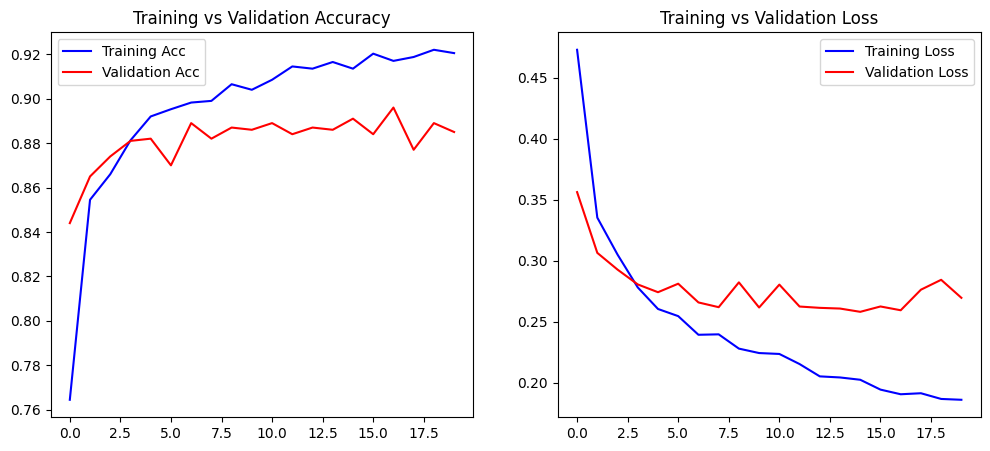

In [42]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history2)


### Test for Overfitting

Training accuracy steadily increases from ~76% to ~92%, which is expected as the model learns the training data.

Validation accuracy improves initially (up to ~88%) but plateaus early (around epoch 5–7) and then fluctuates without further gains.

Left Plot Interpretation:

This widening gap between training and validation accuracy after epoch 7 suggests the model is overfitting — continuing to memorize training data but failing to generalize better to unseen validation data.

Training loss continuously decreases, reaching a low of ~0.18, indicating the model is optimizing well on training data.

Validation loss initially drops but then starts rising again after ~epoch 7, despite training loss still falling.

Right Plot Interpretation:

This pattern — validation loss rising while training loss falls — is a classic signal of overfitting. The model is becoming too specialized to the training data.

- The training accuracy keeps improving, but validation accuracy stalls.

- The validation loss begins increasing, despite decreasing training loss.

- There's no improvement in generalization after a certain point.

### Explore

### Load Models

In [ ]:
model1 = load_model('best_model1.h5')        # Custom CNN
model2 = load_model('best_model_vgg16.h5')   # Fine-tuned VGG16


### Validation Data

In [ ]:
val_dir = 'data/train'

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

# True labels
y_true = val_generator.classes


Found 1000 images belonging to 2 classes.


### Get Predictions

In [ ]:
# Predictions
y_pred1 = model1.predict(val_generator)
y_pred2 = model2.predict(val_generator)

# Convert probabilities to binary labels
y_pred1 = (y_pred1 > 0.5).astype('int32').flatten()
y_pred2 = (y_pred2 > 0.5).astype('int32').flatten()


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step


### Accuracy, Confusion Matrix, Precision, Recall, F1

In [ ]:
# Custom CNN
print("🔹 Custom CNN Model:")
print("Accuracy:", accuracy_score(y_true, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred1))
print("Classification Report:\n", classification_report(y_true, y_pred1, target_names=['Cat', 'Dog']))

# VGG16
print("\n🔹 VGG16 Model:")
print("Accuracy:", accuracy_score(y_true, y_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred2))
print("Classification Report:\n", classification_report(y_true, y_pred2, target_names=['Cat', 'Dog']))


🔹 Custom CNN Model:
Accuracy: 0.75
Confusion Matrix:
 [[410  90]
 [160 340]]
Classification Report:
               precision    recall  f1-score   support

         Cat       0.72      0.82      0.77       500
         Dog       0.79      0.68      0.73       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000


🔹 VGG16 Model:
Accuracy: 0.896
Confusion Matrix:
 [[447  53]
 [ 51 449]]
Classification Report:
               precision    recall  f1-score   support

         Cat       0.90      0.89      0.90       500
         Dog       0.89      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



### Plot Confusion Matrix

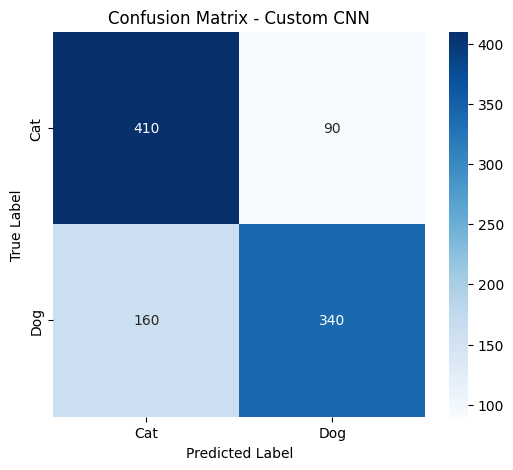

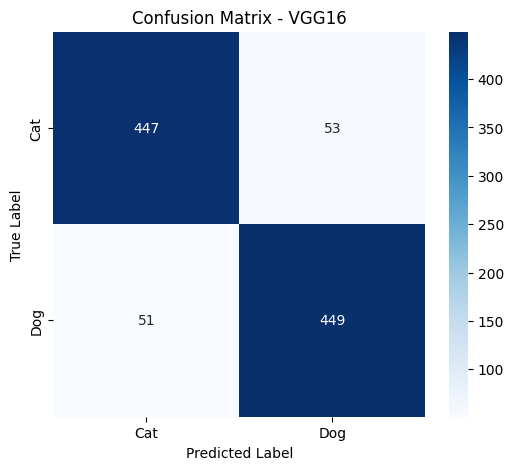

In [18]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Cat', 'Dog']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

plot_confusion_matrix(y_true, y_pred1, model_name="Custom CNN")

plot_confusion_matrix(y_true, y_pred2, model_name="VGG16")

### Precision-Recall Curve

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step


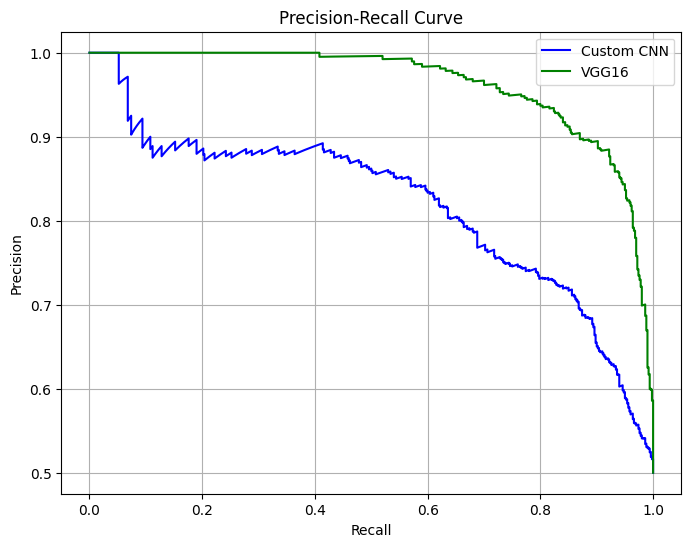

In [ ]:
y_scores1 = model1.predict(val_generator)  # Outputs values in [0, 1]
y_scores2 = model2.predict(val_generator)
# Calculate precision-recall for both models
precision1, recall1, _ = precision_recall_curve(y_true, y_scores1)
precision2, recall2, _ = precision_recall_curve(y_true, y_scores2)

# Plot both
plt.figure(figsize=(8, 6))
plt.plot(recall1, precision1, label='Custom CNN', color='blue')
plt.plot(recall2, precision2, label='VGG16', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


### Visualize Missclassified Images

### VGG16

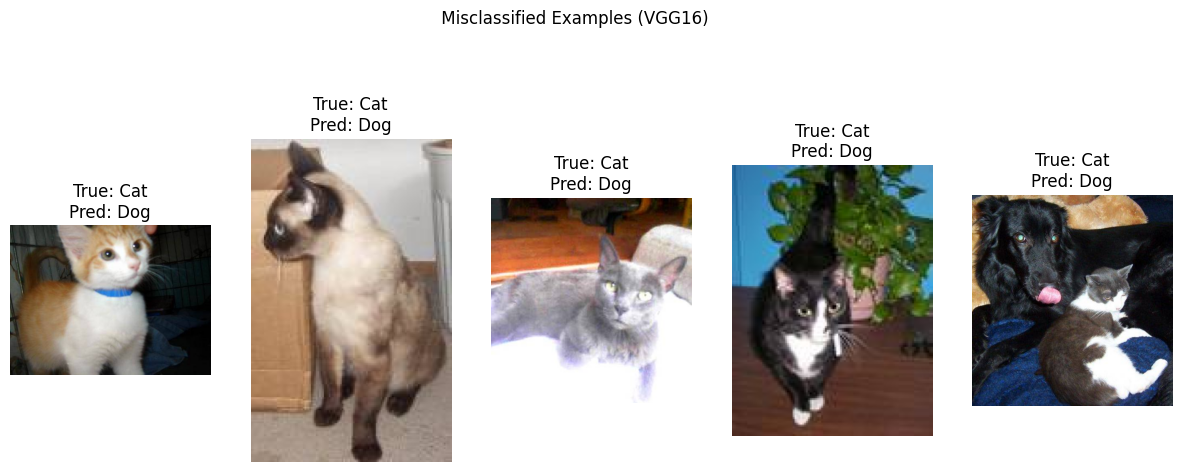

In [ ]:
# Identify misclassified indices
misclassified_indices = np.where(y_pred2 != y_true)[0]

# Get the corresponding file paths
file_paths = [val_generator.filepaths[i] for i in misclassified_indices]

# Show 5 examples
plt.figure(figsize=(15, 6))
for i in range(5):
    img = plt.imread(file_paths[i])
    true_label = 'Dog' if y_true[misclassified_indices[i]] else 'Cat'
    pred_label = 'Dog' if y_pred2[misclassified_indices[i]] else 'Cat'
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.suptitle(" Misclassified Examples (VGG16)")
plt.show()


### CNN

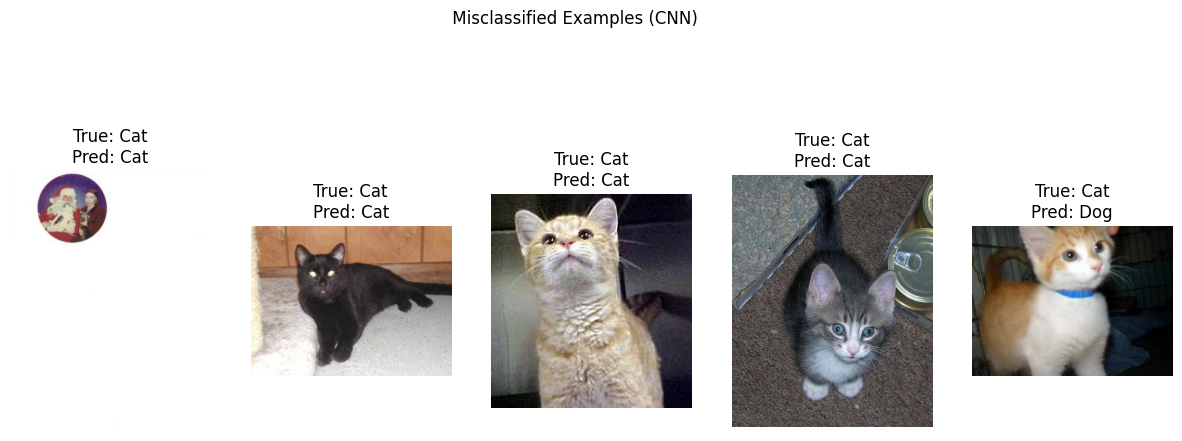

In [22]:
misclassified_indices = np.where(y_pred1 != y_true)[0]

# Get the corresponding file paths
file_paths = [val_generator.filepaths[i] for i in misclassified_indices]

# Show 5 examples
plt.figure(figsize=(15, 6))
for i in range(5):
    img = plt.imread(file_paths[i])
    true_label = 'Dog' if y_true[misclassified_indices[i]] else 'Cat'
    pred_label = 'Dog' if y_pred2[misclassified_indices[i]] else 'Cat'
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.suptitle(" Misclassified Examples (CNN)")
plt.show()


## Conclusion

This project involved the development and evaluation of two deep learning models for binary image classification (Cats vs. Dogs):

1. A custom Convolutional Neural Network (CNN)
2. A fine-tuned VGG16 model pretrained on ImageNet

### Data Preparation

- A balanced dataset of 5,000 images (2,500 cats and 2,500 dogs) was used.
- All images were resized to 150×150 pixels and normalized.
- The dataset was split into training and validation sets using an 80/20 split.

### Model Performance Comparison

| Metric           | Custom CNN | VGG16 (Fine-tuned) |
|------------------|------------|--------------------|
| Accuracy         | 0.75       | 0.90               |
| Precision (Cat)  | 0.72       | 0.90               |
| Recall (Cat)     | 0.82       | 0.89               |
| F1-score (Cat)   | 0.77       | 0.90               |
| Precision (Dog)  | 0.79       | 0.89               |
| Recall (Dog)     | 0.68       | 0.90               |
| F1-score (Dog)   | 0.73       | 0.90               |

The **VGG16 model significantly outperformed the custom CNN**, achieving higher scores across all metrics. The VGG16 model benefited from transfer learning and demonstrated stronger generalization on the validation set.

### Confusion Matrix Insights

- **Custom CNN** misclassified:
  - 90 cat images as dogs
  - 160 dog images as cats
- **VGG16** misclassified:
  - Only 53 cat images and 51 dog images

This indicates the custom CNN had particular difficulty identifying dogs correctly, reflected by its lower recall (0.68) for the "Dog" class.

### Overfitting and Generalization

- The custom CNN began to overfit after a few epochs, with validation accuracy plateauing and validation loss increasing.
- VGG16 showed better generalization due to its pretrained layers and the use of dropout and early stopping.

### Misclassified Example Analysis

- Many misclassified images were visually ambiguous, poorly lit, or depicted animals in unusual poses.
- Some images included mixed context (e.g., animals in cluttered environments), suggesting the model may have relied on background cues.

### Final Remarks

- Transfer learning via VGG16 provided strong performance with minimal tuning, making it an effective baseline model for this task.
- The custom CNN, while simpler, lacked the capacity to extract deep features and struggled to generalize.
- Future improvements may include:
  - Incorporating more aggressive data augmentation
  - Fine-tuning more VGG16 layers
  - Testing other architectures such as ResNet or EfficientNet
  - Visualizing model attention using Grad-CAM to interpret decision-making

Overall, VGG16 demonstrated robust and reliable performance for binary image classification and is recommended for deployment or further experimentation.
